# Cat Face Mapper - Image Regression with FastAI


> In the blog post, we explore key-point modelling using FastAI and build a small application to test our models.


- toc: true 
- badges: true
- comments: true
- author: Mehul Jain
- categories: [image_regression , deep_learning , transfer_learning]

Image regression is the approach of learning from  a dataset where the independent variable is an image and the dependent variable is one or more floats. In this blog post, we will learn how to create a key-point model with FastAI. A  key-point model is a variant of image regression. It is used to predict the location of a specific point(s) in an image. 

To create our key-point model, we will be using [ the CAT dataset](https://www.kaggle.com/crawford/cat-dataset) from Kaggle. It contains over 9,000 cat images. For each image, there are annotations for nine points on the face of a cat, two for eyes, one for mouth, and six for ears. Our task is to predict the locations of these points with our key-point model.

##Downloading the dataset

The first task in our pipeline is to download our dataset from Kaggle. In my previous blog posts, I have explained how to download a Kaggle dataset directly into the Google Drive. So, be sure to check those out if you want more explanation about what is going on here. Or, you can just copy the code shown here and use it in your work. Also, all the code shown here is implemented in Google Colab but you can use the  notebook server of your choice. OK!!! Let's start.



*Mounting the google drive*

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


*Where should the dataset be downloaded?*

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle/Cats" 
%cd /content/gdrive/My Drive/kaggle/Cats

/content/gdrive/My Drive/kaggle/Cats


*Downloading the dataset from Kaggle*

In [ ]:
!kaggle datasets download -d crawford/cat-dataset

100% 4.03G/4.04G [01:20<00:00, 85.1MB/s]
100% 4.04G/4.04G [01:20<00:00, 53.6MB/s]


*Unzipping the files*

In [ ]:
#collapse-output
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: cats/CAT_05/00001130_020.jpg  
  inflating: cats/CAT_05/00001130_020.jpg.cat  
  inflating: cats/CAT_05/00001130_023.jpg  
  inflating: cats/CAT_05/00001130_023.jpg.cat  
  inflating: cats/CAT_05/00001130_026.jpg  
  inflating: cats/CAT_05/00001130_026.jpg.cat  
  inflating: cats/CAT_05/00001131_003.jpg  
  inflating: cats/CAT_05/00001131_003.jpg.cat  
  inflating: cats/CAT_05/00001131_026.jpg  
  inflating: cats/CAT_05/00001131_026.jpg.cat  
  inflating: cats/CAT_05/00001132_007.jpg  
  inflating: cats/CAT_05/00001132_007.jpg.cat  
  inflating: cats/CAT_05/00001132_008.jpg  
  inflating: cats/CAT_05/00001132_008.jpg.cat  
  inflating: cats/CAT_05/00001132_014.jpg  
  inflating: cats/CAT_05/00001132_014.jpg.cat  
  inflating: cats/CAT_05/00001132_017.jpg  
  inflating: cats/CAT_05/00001132_017.jpg.cat  
  inflating: cats/CAT_05/00001132_018.jpg  
  inflating: cats/CAT_05/00001132_018.jpg.cat  
  inflating: cats/CAT_05/0000

*What files are present in the current directory?*



In [ ]:
!ls

CAT_00	CAT_01	CAT_02	CAT_03	CAT_04	CAT_05	CAT_06	cats  kaggle.json


## Data preprocessing and DataBlock

Once we have downloaded the dataset, we can work on our data preprocessing pipeline. In FastAI, preprocessing is carried out using the DataBlock API. To use it, we create a DataBlock object and pass in some details about how the data should be pre-processed. And then, it basically takes care of all the preprocessing steps for us.

 
But first, let's download the latest version of FastAI.

In [3]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 188 kB 8.3 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 


Now let's import the required modules.

In [ ]:
from fastai.vision.all import *
from pathlib import Path
import numpy as np
import os

 Before building a DataBlock, we will explore how our data is organized. In the previous section, we saw that there is a folder named  'cats' in the directory where we downloaded the dataset. This folder contains the images we are going to use. 

In [ ]:
path=Path(os.getcwd()+'/cats')
path

Path('/content/gdrive/My Drive/kaggle/Cats/cats')

For the sake of convenience, we can store the path where our dataset is located in the BASE_PATH attribute of the Path class.   

In [ ]:
Path.BASE_PATH=path
Path.BASE_PATH

Path('.')

Now, let's find out what's inside the 'cats' folder. 

In [ ]:
path.ls().sorted()

(#7) [Path('CAT_00'),Path('CAT_01'),Path('CAT_02'),Path('CAT_03'),Path('CAT_04'),Path('CAT_05'),Path('CAT_06')]

The 'cats' folder contains sub-folders with names like 'CAT__00', 'CAT__01' , etc. But, what's inside them ?

In [ ]:
(path/'CAT_00').ls().sorted()

(#3413) [Path('CAT_00/00000001_000.jpg'),Path('CAT_00/00000001_000.jpg.cat'),Path('CAT_00/00000001_005.jpg'),Path('CAT_00/00000001_005.jpg.cat'),Path('CAT_00/00000001_008.jpg'),Path('CAT_00/00000001_008.jpg.cat'),Path('CAT_00/00000001_011.jpg'),Path('CAT_00/00000001_011.jpg.cat'),Path('CAT_00/00000001_012.jpg'),Path('CAT_00/00000001_012.jpg.cat')...]

Each of these sub-folders contains different images of cats along with '.cat' files which have the co-ordinates of face points for a their corresponding image. 

We need to create a function that can return the '.cat' file for a given image. We can accomplish this by simply adding '.cat' to the end of a jpg file. 

In [ ]:
img_files=get_image_files(path)
def img2face(x): #returns the co-ordinates file for a given image
  return Path(f'{str(x)[:-4]}.jpg.cat')
img2face(img_files[1]) #testing the function on an image from the dataset

Path('CAT_00/00000390_001.jpg.cat')

Now, let's take a look at an image from our dataset.


In [ ]:
im=PILImage.create(img_files[0])
im,shape #what is the shape of our image

(PILImage mode=RGB size=500x279, None)

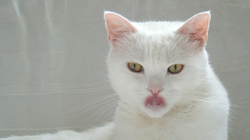

In [ ]:
im.to_thumb(250)

We still need to find a way to read the co-ordinates from the '.cat' files. Luckily, Numpy provides us the `genfromtxt` function which can be used to load data from a text file. So, let's try this function and see what we get.

In [ ]:
face=np.genfromtxt(path/'CAT_00'/'00000001_000.jpg.cat')[1:]
face

array([175., 160., 239., 162., 199., 199., 149., 121., 137.,  78., 166.,
        93., 281., 101., 312.,  96., 296., 133.])

We can apply the `img2face` and `genfromtxt` functions to get the corresponding co-ordinates file for an image and get the face points from that file. We encapsulate all this functionality in another function which will be useful while building our DataBlock. Let's call this function `get_face_points`.

In [7]:
def get_face_points(f):
  face_points=np.genfromtxt(img2face(f))[1:]
  return tensor(face_points)

We can test our `get_face_points` function by  passing in the path of an image file. As you can see below, the function returns the co-ordinates present in the file.


In [ ]:
get_face_points(img_files[0])

tensor([269., 132., 352., 134., 310., 187., 222.,  92., 210.,  24., 276.,  61.,
        352.,  63., 417.,  26., 406.,  97.])

Let's mark these co-ordinates on the image and see if they actually represent the position of the facial features. 

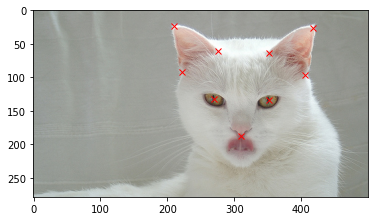

In [ ]:
from matplotlib import image
from matplotlib import pyplot as plt

# to read the image stored in the working directory
data = image.imread(img_files[0])

#get the x,y coordinates
t=get_face_points(img_files[0])
xs=[t[i] for i in range(18) if i%2==0]
ys=[t[i] for i in range(18) if i%2!=0]
coords=[(float(i),float(j)) for i,j in zip(xs,ys)]

for i,j in coords:
  plt.plot(i,j,marker='x',color='red')
plt.imshow(data)
plt.show()

Nice!!! Our `get_face_points` function returns the co-ordinates perfectly. Now, we will build our DataBlock. To create a DataBlock, we need to pass in the following details:

*   Type of independent and dependent variable (our independent variables are images and the dependent variables are points )
*   A function to get the independent variables or images in our case (`get_image_files`) . 
*   A function to get the values of the dependent variable, which are the co-ordinates of facial features (`get_face_points` ).
*  A method to split the dataset into training and validation set (`FuncSplitter`).
*  Finally, item and batch transforms. Transforms allow us to manipulate our data. They are used to convert the images into the desired format and perform data augmentation.  Here, we are using the `Resize` item transform which reshapes all the images into one shape (500,500).



In [ ]:
cats=DataBlock(
    blocks=(ImageBlock,PointBlock),
    get_items=get_image_files,
    get_y=get_face_points,
    splitter=FuncSplitter(lambda o: o.parent.name=='CAT_06'),
    item_tfms=Resize(size=500,method='squish')
)

Using our DataBlock, we create a dataloader. A dataloader divides our dataset into batches which can be fed into the model one at a time. Each batch is of the form: `((X1,X2,X3...),(Y1,Y2,Y3...))` where X1,X2,X3 are images and Y1,Y2,Y3 are co-ordinates corresponding to the images.

Let's look at a batch from our dataloader.

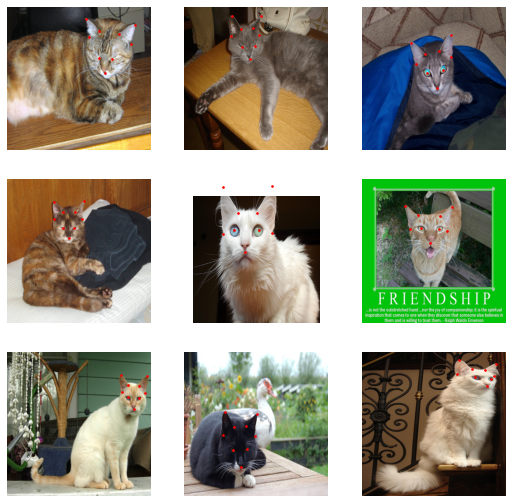

In [ ]:
dls=cats.dataloaders(path)
dls.show_batch()

We can also look at the shape of the independent and dependent variables to understand how the data is organized in a batch.

In [ ]:
xb, yb= dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 500, 500]), torch.Size([64, 9, 2]))

Each batch in our dataloader has 64 RGB images of the size (500,500) and the corresponding x and y co-ordinates of the nine face points.  

In [ ]:
yb[0] #the 2 in the final axis of the shape represents x and y co-ordinates 

TensorPoint([[-0.3080, -0.1650],
        [ 0.0080, -0.2050],
        [-0.1240,  0.1400],
        [-0.5360, -0.2850],
        [-0.6160, -0.7000],
        [-0.3400, -0.5200],
        [-0.0440, -0.5700],
        [ 0.1800, -0.8450],
        [ 0.1920, -0.3850]], device='cuda:0')

## ResNet18 Key-Point Model

Our data is ready, let's focus on creating our key-point model. We will use transfer learning and fine-tune a pretrained model instead of creating one from scratch. This is because training an accurate model from scratch will take a lot of time (hundreds of epochs) and compute power. On the other hand, transfer learning will help us in creating a model quickly, with less data while simultaneously ensuring top-notch results.

For our pretrained model, we will use the ResNet18 architecture trained on ImageNet. FastAI provides us with the `cnn_learner` convenience function to easily create and train a CNN model. All we need to do is pass in our dataloader, the architecture we want to use and the range of our targets. Our `y_range` (target range) is between -1 to +1. This is because coordinates in FastAI and PyTorch are always rescaled between -1 and +1.

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Notice that we did not mention a loss function in the `cnn_learner` but it still worked. This is because it uses the default loss function provided by FastAI. So, what is the default loss function for our key-point model?

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

Using an optimal learning rate is essential for ensuring that our model learns at the proper pace and finds the lowest possible value for the loss. The `lr_find` function in FastAI  finds an optimal learning rate for us and returns a plot depicting the relationship between loss value and learning rate. 

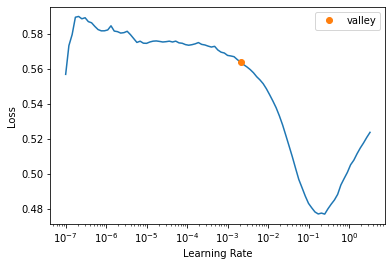

In [ ]:
lr=learn.lr_find()

What is the suggested learning rate by `lr_find`?

In [ ]:
lr[0]

0.0020892962347716093

With all the pieces in the right place, we can start the training process. To fine-tune our model, we need to pass in the number of epochs and the learning rate in the `fine_tune` function of our `cnn_learner` object. We will train our model for 20 epochs and see how accurate our model gets.

In [ ]:
learn.fine_tune(20,lr[0])

epoch,train_loss,valid_loss,time
0,0.346460,0.123529,32:17


epoch,train_loss,valid_loss,time
0,0.171530,0.090876,04:57
1,0.125122,0.069474,04:53
2,0.081517,0.044853,04:53
3,0.050499,0.036057,04:55
4,0.034669,0.021600,04:56
5,0.025236,0.023799,04:56
6,0.021619,0.020361,04:56
7,0.018498,0.014436,04:56
8,0.015099,0.012759,04:55
9,0.013344,0.012700,04:55


That's quite the result. We got to a loss of around 0.0074 with just 20 epochs. We can also plot the training and validation loss for the whole learning process. 

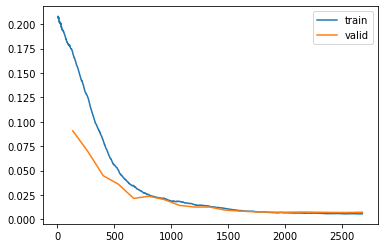

In [ ]:
learn.recorder.plot_loss()

Numbers are hard to understand, so let's see the results and compare our predictions with the ground truth.

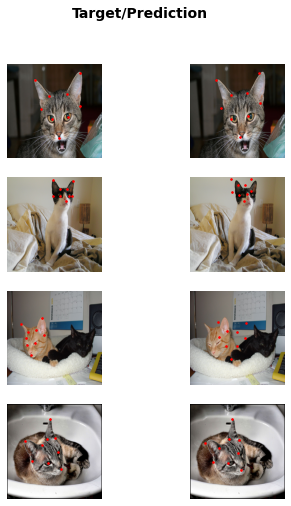

In [ ]:
learn.show_results(ds_idx=1, nrows=4, figsize=(6,8))

Indeed, our model has become quite good at this task. 

Since training our model took a while, it would be wise to save it in memory so  we can just load it whenever required.

In [ ]:
learn.export() #we can name the model also

## Trying a deeper architecture - ResNet34

In the previous section, we used the ResNet18 architecture and got a loss of around 0.0074. But we can do better. We can use a deeper architecture. Deeper architectures usually model the data more accurately as compared to shallower ones. In general, a bigger model has the ability to better capture the real underlying relationships in your data, and also to capture and memorize the specific details of your individual images. But they require more compute power during training. Also, they take quite a bit longer to train. 

One technique that can speed things up a lot is mixed-precision training. This refers to using less-precise numbers (half-precision floating point, also called fp16) wherever possible during training. This can speed up the training process by 2-3x. It also reduces memory usage during training. To enable this feature in FastAI, we just have to add `to_fp16()` after our `cnn_learner` creation . 

Let's switch to ResNet34 to get better results in our task. To use ResNet34 ,we just need change the architecture we passed in the `cnn_learner` to `resnet34`. Rest all the details remain the same.  

In [ ]:
learn = cnn_learner(dls, resnet34, y_range=(-1,1)).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


What's the loss function?

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

Using `lr_find` to get an optimal learning rate.

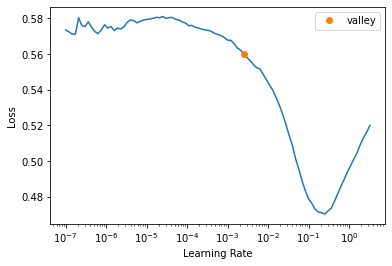

In [ ]:
lr=learn.lr_find()

What is the suggested learning rate?

In [ ]:
lr[0]

0.002511886414140463

Now, let's fine-tune our ResNet34 architecture for 20 epochs and see if there is any improvement.

In [ ]:
learn.fine_tune(20,lr[0])

epoch,train_loss,valid_loss,time
0,0.322153,0.112187,37:05


epoch,train_loss,valid_loss,time
0,0.135973,0.067399,06:31
1,0.076629,0.036782,06:28
2,0.040184,0.027252,06:27
3,0.025203,0.042123,06:27
4,0.021205,0.011077,06:28
5,0.019296,0.012121,06:27
6,0.019582,0.015632,06:27
7,0.018242,0.011337,06:29
8,0.015452,0.009075,06:27
9,0.015463,0.008312,06:28


As you can see, ResNet34 manages to get a lower loss than the ResNet18. We might get a better loss value if we train this model for some more epochs. So go ahead and try it !!!

Let's look at the loss plot.

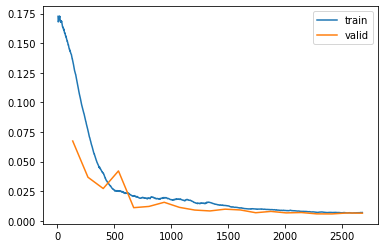

In [ ]:
learn.recorder.plot_loss()

Finally, let's look at the results from this model.

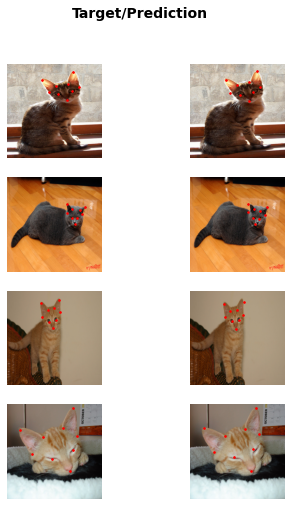

In [ ]:
learn.show_results(ds_idx=1, nrows=4, figsize=(6,8))

Again, saving the model now will save you from a lot of trouble later.

In [ ]:
learn.export('export2.pkl') #we can name the model also

The results from both our models are great. Till now, we have trained two highly accurate models that can predict the co-ordinates of facial features in the image of a cat. Next, let's have some fun!!!

## Cat Face Mapper Application

The real test of any model's effectiveness is to see if it works on random unseen data. In this section, we will create a small application to see if our models work on unseen images. We will create a GUI with ipywidgets where you can upload a photo of a cat and see the output produced by our models. 

In [8]:
#collapse-hide
from fastai.vision.all import *
from fastai.vision.widgets import *
import matplotlib.pyplot as plt
from pathlib import Path

Let's see if our saved models are present in the current directory.

In [9]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('export.pkl'),Path('export2.pkl')]

OK, now let's load the models.

In [10]:
learn_inf=load_learner(path/'export.pkl')
learn_inf2=load_learner(path/'export2.pkl')

Initializing the widgets we are going to use in our GUI.

In [11]:
btn_upload=widgets.FileUpload() #upload button
btn_fpoints=widgets.Button(description='Get Face Points') #button that produces the final output 
lbl_orig = widgets.Label() #original image label 
out_pl=widgets.Output() #output original image
model_select=widgets.Dropdown(
    options=[('Resnet18',1),('Resnet34',2)],
    value=1,
    description="Select model:") #dropdown to select the model Resnet18 or Resnet34 

Since our models output co-ordinates, we can't tell if they actually work unless we mark those co-ordinates on the image. So, we will create a function that marks the output co-ordinates on our input (uploaded) image. 

In [12]:
def show_pred(img,coords):
  w,h=img.size
  for i,j in coords:
    plt.plot((i/500)*w,(j/500)*h,marker='x',color='red')
  plt.imshow(img)

Our GUI has a `Get Face Points` button which will display the output predictions from the selected model when clicked. For this to happen, we need to create an event handler that does the following things when the `Get Face Points` button is clicked:  
1.   Load the uploaded image.
2.   Generate predictions on the uploaded image using the selected model (ResNet18 or ResNet34).
3.   Mark the predictions (co-ordinates) on the input image.
4. Display the final output (image with co-ordinates marked on it ) .
 

In [13]:
def on_click_fpoints(change):
  img=PILImage.create(btn_upload.data[-1])
  lbl_orig.value=f'Uploaded Image:'
  out_pl.clear_output()
  with out_pl:display(img.to_thumb(256,256))
  ind=model_select.index
  if ind==0:
    preds,_,_=learn_inf.predict(img)
    print('Model: Resnet18 , Output Image:')
  elif ind==1:
    preds,_,_=learn_inf2.predict(img)
    print('Model: Resnet34 , Output Image:')
  show_pred(img,preds)

btn_fpoints.on_click(on_click_fpoints) #what to do when button is clicked 

Lastly, we need to build a layout for our GUI. 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Model: Resnet18 , Output Image:


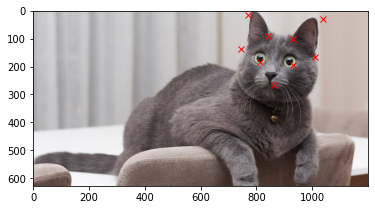

Model: Resnet34 , Output Image:


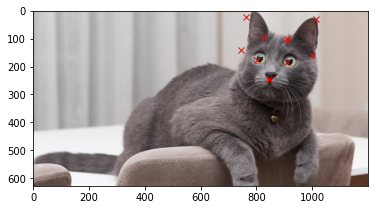

In [14]:
VBox([widgets.Label('Cat face mapper!'), 
      btn_upload,
      model_select,
      btn_fpoints,
      lbl_orig,
      out_pl])

Voila!!! Our **Cat Face Mapper** works. 

##Conclusion

In this blog post, we learned how to perform image regression using FastAI. Specifically, we built a key-point model that predicts the co-ordinates of facial features in cat images. We used transfer learning for creating our image regression model with the pretrained model being ResNet18. We also experimented with ResNet34 and saw how deeper architectures can produce better results. Finally, we built a fun application to test our models on random unseen images. 

Note that the same technique can be used to create a model for detecting facial features in human photos. Be sure to experiment with the code shown here and apply it on other image regression datasets.  

*See you on the next adventure!!!*